In [119]:
import os

import time

import numpy as np

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea

In [120]:
def confidence_ellipse(cov, centroid, ax, n_std=2.0, facecolor='none', **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = centroid[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = centroid[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [121]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

# An asymptotic result for the Stochastic block model SIS

Consider now an individual-based model with individual-specific covariates $w_n$ given by $(l_n, c_n)$ where $l_n \in [3]$ is a number between $1$ and $3$ representing the community the individual is assigned to, and we denote with $C_i$ the number of individuals in community $i$, i.e. $C_i=\sum_{n \in [N]}\mathbb{I}(l_n=i)$ while $c_n$ is a 2-dimensional vector where $c_n^{(1)}=1$ and $c_n^{(2)} \in \{-1,0,1\}$ is a covariate which is set deterministically according to the community the individual is in, and specifically $c_n=-1$ if $l_n=1$, $c_n=0$ if $l_n=2$, and so on. The probability of being assign to the different community is $[0.4, 0.3, 0.3]$ and we consider the following model:
$$
    p_0(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1-p_{0}\\ p_{0} 
    \end{bmatrix}, \quad \text{ with } p_{0}=0.01
$$
$$
    \eta_{t-1}^N(w_n,\theta)
    =
    \frac{1}{N} \sum_{\tilde{n} \in [N]\setminus n} \begin{bmatrix}
    0\\
    \frac{N}{C_{l_{\tilde{n}}}} B^{(l_n,l_{\tilde{n}})}
    \end{bmatrix}^\top x_{t-1}^N(w_{\tilde{n}}), \quad \text{ with }  
    B =
    \begin{bmatrix}
    	0.80 & 0.50 & 0.00 \\
	0.50 & 0.60 & 0.05 \\
	0.00 & 0.05 & 0.10
    \end{bmatrix}, \epsilon = 0.001
$$
$$
    K_{\eta_{t-1}^N(w_n,\theta)}(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1 - \frac{\eta_{t-1}^N(w_n,\theta) +\epsilon }{1 + \exp{(-\beta_{I}^\top c_n)}}
    & 
    \frac{\eta_{t-1}^N(w_n,\theta) +\epsilon }{1 + \exp{(-\beta_{I}^\top c_n)}}\\ 
    \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}}
    & 
    1- \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}}
    \end{bmatrix}, \quad \text{ with } \beta_{I} = [1, -1]^\top, \beta_{R} = [1, 0.5]^\top
$$
$$
    G(w_n,\theta) 
    =
    \begin{bmatrix}
    1 - q_T^{(1)} 
    & 
    q_T^{(1)} q_{Se}  
    & 
    q_T^{(1)} (1-q_{Se})\\
    1 - q_T^{(2)} 
    & 
    q_T^{(2)} (1- q_{Sp}) 
    & 
    q_T^{(2)} q_{Sp}
    \end{bmatrix}, \quad \text{ with } q_T = [0.1, 0.5]^\top, q_{Se} =1, q_{Sp} = 1
$$
where $p_0$ is the probability of being infected at the beginning of the epidemic, $B$ is matrix tells us the probability of a contact between two communities, $\epsilon$ is an environmental effect, $\beta_I$ are the logistic regression coefficients for the infectious rate, $\beta_R$ are the logistic regression coefficients for the recovery rate, $q_T$ is the vector of reporting probabilities with $q_T^{(1)}$ being reported as a susceptible and $q_T^{(2)}$ as an infected, $q_{Se}$ and $q_{Sp}$ are the sensitivity and specificity of the test. Essentially at each time step each individual interacts with the others according to a stochastic block model with a probability matrix that is given by $B$.

In [122]:
Ncommunities = 3

B = tf.convert_to_tensor([[0.80, 0.50, 0.00],
			  [0.50, 0.60, 0.05],
			  [0.00, 0.05, 0.10]], dtype = tf.float32)

N = 1000000

prior_community_distribution = tf.convert_to_tensor([0.4, 0.3, 0.3], dtype = tf.float32)

communities = tfp.distributions.Categorical(probs = prior_community_distribution).sample(N)
communities = tf.one_hot(communities, Ncommunities)

prior_covariates = tf.convert_to_tensor([-1.0, 0.0, +1.0], dtype = tf.float32)

covariates = tf.einsum("nc,c->n", communities, prior_covariates)
covariates = tf.stack((tf.ones(tf.shape(covariates)), covariates), axis = 1)

In [123]:
# N = 1000
# parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
#               "B_matrix":B,
#               "beta_l":tf.convert_to_tensor([1, -1.0], dtype = tf.float32),
#               "beta_g":tf.convert_to_tensor([1, +0.5], dtype = tf.float32),
#               "logit_sensitivity":logit(
#                 tf.convert_to_tensor([1.0], dtype = tf.float32)),
#               "logit_specificity":logit(
#                 tf.convert_to_tensor([1.0], dtype = tf.float32)),
#               "logit_prob_testing":logit(
#                 tf.convert_to_tensor([0.1, 0.5], dtype = tf.float32)),
#               "log_epsilon":tf.math.log(
#                 tf.convert_to_tensor([0.001], dtype = tf.float32)),}

# SIS = sbm_SIS_finite(communities[:N,...], covariates[:N])

# n_sim = 100
# Time  = 100
# X, Y = simulator(SIS, parameters, Time, sample_size = n_sim)

In [124]:
# fig, ax = plt.subplots(2, 3, figsize = (15, 10), sharex=True, sharey=True)

# X_communities = tf.einsum("...nm,nc->...cm", X, communities[:N,...])
# Y_communities = tf.einsum("...nm,nc->...cm", Y, communities[:N,...])

# time = np.linspace(0, Time, Time+1)

# communities_names = ["Community 1", "Community 2", "Community 3"]

# for sim in range(50):

# 	for c in range(3):

# 		ax[0,c].plot(time, X_communities[:,sim, c, 0], color = "green", alpha = 0.1, label = "susceptible")
# 		ax[0,c].plot(time, X_communities[:,sim, c, 1], color = "red", alpha = 0.1, label = "infected")

# 		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 0], color = "blue", alpha = 0.1, label = "unreported")
# 		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 1], color = "green", alpha = 0.1, label = "susceptible")
# 		ax[1,c].plot(time[1:], Y_communities[:,sim, c, 2], color = "red", alpha = 0.1, label = "infected")


# 		ax[0,c].set_title(communities_names[c])
# 		ax[1,c].set_xlabel("time")

# 		if c==0:
# 			ax[0,c].set_ylabel("counts")
# 			ax[1,c].set_ylabel("counts")

# 		if sim==0:
# 			legend1 =  ax[0,c].legend(loc = "upper right")

# 			for handle in legend1.legend_handles:
#     				handle.set_alpha(1)
				    
# 			legend2 =  ax[1,c].legend(loc = "upper right")

# 			for handle in legend2.legend_handles:
#     				handle.set_alpha(1)


# plt.tight_layout()
# plt.savefig('Figures/sbm_simulation_communities.png', format='png', dpi=100, bbox_inches='tight')

In [125]:
prior_covariates_stacked = tf.stack((tf.ones(tf.shape(prior_covariates)), prior_covariates), axis = 1)

SIS_limit = sbm_SIS_finite(tf.eye(3), prior_covariates_stacked)

pi_0_inf = SIS_limit.pi_0(parameters)

def body(input, t):

	pi_tm1_inf = input

	return tf.einsum("ci,cij->cj", pi_tm1_inf, SIS_limit.K_x(parameters, pi_tm1_inf))

Pi_inf = tf.scan(body, tf.range(0, Time), initializer = pi_0_inf)
Pi_inf = tf.concat((tf.expand_dims(pi_0_inf, axis =0), Pi_inf), axis = 0)

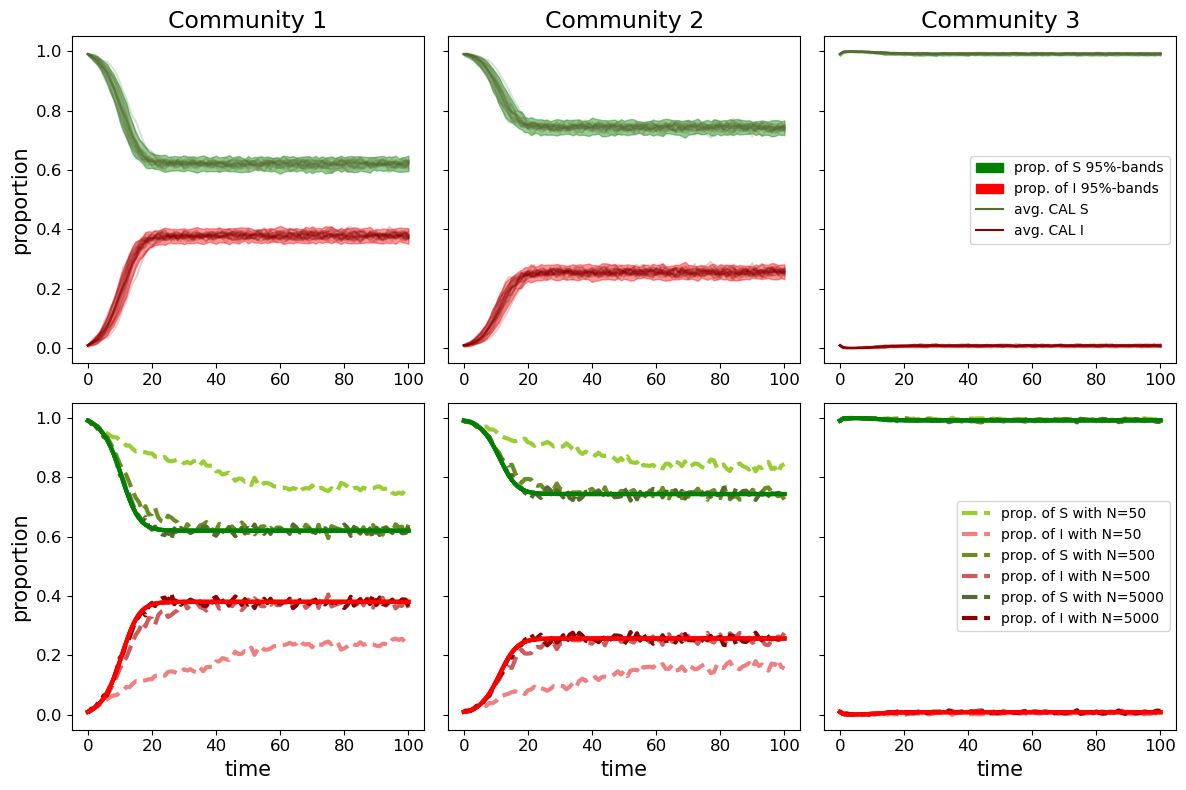

In [127]:
fig, ax = plt.subplots(2, 3, figsize = (12, 8), sharey="row")

N_label = [50, 500, 5000]
labels = [1, 3, 2]

time = np.linspace(0, Time, Time+1)

n_sim = 100

communities_names = ["Community 1", "Community 2", "Community 3"]
color_n_I = ["lightcoral", "indianred", "darkred"]
color_n_S = ["yellowgreen", "olivedrab", "darkolivegreen"]
label_n   = ["N=50", "N=500", "N=5000"]

for n in range(3):
	SIS = sbm_SIS_finite(communities[:N_label[n],...], covariates[:N_label[n],:])

	X, Y = simulator(SIS, parameters, Time, sample_size = n_sim)

	X_communities = tf.einsum("...nm,nc->...cm", X, communities[:N_label[n],...])
	C_size = tf.reduce_sum(communities[:N_label[n],...], axis =0)
	X_communities = tf.einsum("...cm,c->...cm", X_communities, 1/C_size)

	time = np.linspace(0, Time, Time+1)

	communities_names = ["Community 1", "Community 2", "Community 3"]


	if n==2:
		qX_communities = np.quantile(X_communities, (0.025, 0.975), axis =1)
		for c in range(3):
			ax[0,c].fill_between(time, qX_communities[0,:,c,0], qX_communities[1,:,c,0], color = "green", alpha = 0.4, label = r"prop. of S 95%-bands")
			ax[0,c].fill_between(time, qX_communities[0,:,c,1], qX_communities[1,:,c,1], color = "red",   alpha = 0.4, label = r"prop. of I 95%-bands")

		for sim in range(int(n_sim/5)):

			Pi_N, _, _ = CAL_compiled(SIS, parameters, Y[:,sim,:,:])

			Pi_communities = tf.einsum("...nm,nc->...cm", Pi_N, communities[:N_label[n],...])
			C_size = tf.reduce_sum(communities[:N_label[n],...], axis =0)
			Pi_communities = tf.einsum("...cm,c->...cm", Pi_communities, 1/C_size)

			for c in range(3):

				if sim==0:
					ax[0,c].plot(time, Pi_communities[:, c, 0], color = color_n_S[n], alpha = 0.2, label = "avg. CAL S")
					ax[0,c].plot(time, Pi_communities[:, c, 1], color = color_n_I[n],   alpha = 0.2, label = "avg. CAL I")
				else:
					ax[0,c].plot(time, Pi_communities[:, c, 0], color = color_n_S[n], alpha = 0.2)
					ax[0,c].plot(time, Pi_communities[:, c, 1], color = color_n_I[n],   alpha = 0.2)

	for c in range(3):

		X_reweighted = tf.einsum("...nm,nc->...cm", X[...,:N_label[0],:], communities[:N_label[0],...]/tf.reduce_sum(communities[:N_label[0],...], axis = 0, keepdims=True))

		X_empirical = tf.reduce_mean(X_reweighted[...,c,:], axis = 1)

		ax[1, c].plot(time, X_empirical[:, 0], color = color_n_S[n], linestyle='dashed', linewidth=3, label = "prop. of S with "+label_n[n])
		ax[1, c].plot(time, X_empirical[:, 1], color = color_n_I[n], linestyle='dashed', linewidth=3, label = "prop. of I with "+label_n[n])

		ax[1, c].plot(time, Pi_inf[:,c, 0], color = "green", linewidth=3)
		ax[1, c].plot(time, Pi_inf[:,c, 1], color = "red", linewidth=3)		

legend1 =  ax[0,2].legend()

for handle in legend1.legend_handles:
	handle.set_alpha(1)

ax[1, 2].legend()

for c in range(0,3):		

	ax[0, c].set_title(communities_names[c])
	ax[1, c].set_xlabel("time")

	if c==0:
		ax[0, c].set_ylabel("proportion")
		ax[1, c].set_ylabel("proportion")

plt.tight_layout()

plt.savefig('Figures/sbm_limiting_distribution.png', format='png', dpi=100, bbox_inches='tight')

# Spatial model

Consider an individual-based SIS model with the covariates $w_n$ given by $(l_n, c_n)$ where $l_n$ is a location in space and $c_n$ are some individual-specific characteristics. Specifically, given a population size of $N$ and $10$ cities represented by bivariate Gaussian we assigns $\frac{N}{10}$ individuals to each city and then draw $l_n$ from the corresponding bivariate Gaussian. Note that we could equivalently randomly assign each individual to a city with a certain probability. $c_n$ is a bivariate vector with the first component set to $1$ and the second component drawn from a Gaussian with mean $0$ and standard deviation $1$.

Then consider the following individual-specific initial distribution, transition kernel and emission distribution:
$$
    p_0(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1-p_{0}\\ p_{0} 
    \end{bmatrix},
$$
$$
    \eta_{t-1}^N(w_n,\theta)
    =
    \frac{\chi}{N} \sum_{\tilde{n} \in [N]\setminus n} \begin{bmatrix}
    0\\
    \phi(||{l_n - l_{\tilde{n}}}||;0,\sqrt{\phi})
    \end{bmatrix}^\top x_{t-1}^N(w_{\tilde{n}}),
$$
$$
    K_{\eta_{t-1}^N(w_n,\theta)}(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1 - \frac{\eta_{t-1}^N(w_n,\theta)}{1 + \exp{(-\beta_{I}^\top c_n)}} 
    & 
    \frac{\eta_{t-1}^N(w_n,\theta)}{1 + \exp{(-\beta_{I}^\top c_n)}}\\ 
    \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}} 
    & 
    1 - \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}} 
    \end{bmatrix},
$$
$$
    G(w_n,\theta) 
    =
    \begin{bmatrix}
    1 - q_S 
    & 
    q_S q_{Se}  
    & 
    q_S (1-q_{Se})\\
    1 - q_I 
    & 
    q_I (1- q_{Sp}) 
    & 
    q_I q_{Sp}
    \end{bmatrix},
$$
where $p_0$ is the probability of being infected at the beginning of the epidemic, $\chi$ is the infectious pressure, $\phi$ is the intensity of the spatial kernel, $\beta_I$ are the logistic regression coefficients for the infectious rate, $\beta_R$ are the logistic regression coefficients for the recovery rate, $q_S$ and $q_I$ are the probabilities of being reported as a susceptible and infected, $q_{Se}$ and $q_{Sp}$ are the sensitivity and specificity of the test.

In [ ]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-2.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "log_phi":tf.math.log(
                tf.convert_to_tensor([2.0], dtype = tf.float32)),
              "log_chi":tf.math.log(
                tf.convert_to_tensor([50.0], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
		"log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}

T = 200
n_covergage = 100
n_gradient_steps = 1000
n_trial = 10

In [ ]:
N_pop = 1000
covariates = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)[:N_pop,:]
centroids  = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/centroids.npy"), dtype = tf.float32)
cities_std = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/cities_std.npy"), dtype = tf.float32)

In [ ]:
SIS = spatial_SIS(locations, covariates)

start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
	for j in range(4):

		t = 10*(i*4+j)

		infected = tf.where(X[t,0,:,1]==1)[:,0]

		ax[i, j].set_title("Time "+str(t))
		ax[i, j].scatter(locations[:,0], locations[:,1], color = "green", s = 20)
		ax[i, j].scatter(tf.gather(locations[:,0], infected),
					tf.gather(locations[:,1], infected), color = "red", s = 20)
		ax[i, j].scatter(centroids[:,0], centroids[:,1], marker="*", color = "black", s = 10)

		if j==0:
			for city in range(tf.shape(cities_std)[0]):
				confidence_ellipse(tf.linalg.diag(cities_std[city,:]), centroids[city,:], ax[i, j], edgecolor='black')

plt.savefig('Figures/spatial_illustration.png', format='png', dpi=100, bbox_inches='tight')

In [ ]:
learning_parameters = { "beta_l": 2, 
		"beta_g": 2, 
		"log_phi": 1, 
		"log_chi": 1, 
		"logit_prob_testing": 2
		}


ylabel_dict = { "beta_l" : "$\\beta_{I}$", 
		"beta_g" : "$\\beta_{R}$", 
		"log_phi": "$\\log(\\phi)$", 
		"log_chi": "$\\log(\\chi)$", 
		"logit_prob_testing": "$logit(q_T)$"
		}

colors_list         = ["blue", "black", "yellow"]

N_list = [500, 1000, 2000]

fig, ax = plt.subplots(len(learning_parameters)+1, len(N_list), figsize = (len(N_list)*4, (len(learning_parameters)+1)*2), sharex=True)

# ax[0,0].set_ylabel("normalized loss")
# ax[1,0].set_ylabel(r"$\log(\phi)$")
# ax[2,0].set_ylabel(r"$\beta_{\gamma}$")

# ax[len(learning_parameters),0].set_xlabel("iterations")
# ax[len(learning_parameters),1].set_xlabel("iterations")
# ax[len(learning_parameters),2].set_xlabel("iterations")

for n_index in range(len(N_list)):
	N = N_list[n_index]

	ax[0,n_index].set_title(r"$N=$"+str(N))

	output_path = "Data/SpatialInference/Output/"+str(N)+"/"
	true_loss_file_name        = "spatial_inference_"+str(N)+"_true_loss.npy"
	optim_loss_file_name       = "spatial_inference_"+str(N)+"_optim_loss.npy"
	optim_parameters_file_name = "spatial_inference_"+str(N)+"_optim_parameters.npy"

	true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
	optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
	optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

	index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

	for i in range(n_covergage):

		if i in index:

			trial_index = np.nanargmin(optim_loss[i,:,-1])

			ax[0, n_index].plot(optim_loss[i,trial_index,:]/true_loss[i], color = "blue", alpha = 0.1)
			ax[0, n_index].axhline(true_loss[i]/true_loss[i], color = "red", alpha = 0.1)
			
			if n_index == 0:
				ax[0, n_index].set_ylabel("loss")	

			counter = 0
			for key in learning_parameters.keys():
				for j in range(learning_parameters[key]):

					ax[counter+1, n_index].plot(optim_parameters[key][i,trial_index,:, j], color = colors_list[j], alpha = 0.1)
					ax[counter+1, n_index].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

				if n_index == 0:
					ax[counter+1, n_index].set_ylabel(ylabel_dict[key])	

				if (counter+1) == len(learning_parameters.keys()):
					ax[counter+1, n_index].set_xlabel("grad steps")
				
				counter = counter +1

plt.savefig('Figures/spatial_inference.png', format='png', dpi=100, bbox_inches='tight')

In [ ]:
# fig, ax = plt.subplots(2, len(learning_parameters), figsize = ((len(learning_parameters))*4, 2*2))

table_dict = {}
counter = 0
for key in learning_parameters.keys():

	table_dict[key] = []

	for j in range(learning_parameters[key]):
		optim_param_list = []
		for n_index in range(len(N_list)):
			N = N_list[n_index]

			output_path = "Data/SpatialInference/Output/"+str(N)+"/"
			true_loss_file_name        = "spatial_inference_"+str(N)+"_true_loss.npy"
			optim_loss_file_name       = "spatial_inference_"+str(N)+"_optim_loss.npy"
			optim_parameters_file_name = "spatial_inference_"+str(N)+"_optim_parameters.npy"

			true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
			optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
			optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

			index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

			trial_index = np.nanargmin(optim_loss[index,...,-1], axis =1)
			to_append = np.stack([optim_parameters[key][trial,trial_index[trial],-1,j] for trial in index])
			# to_append = optim_parameters[key][2,:,-1,j]

			optim_param_list.append(tf.gather(to_append, tf.where(tf.math.is_nan(to_append)==False))[:,0])

		table_dict[key].append(optim_param_list)
		# ax[j,counter].boxplot(optim_param_list, showmeans=True)
		# ax[j,counter].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

	counter = counter +1

In [ ]:
from tabulate import tabulate

In [ ]:
# assign data
table = []

for key in learning_parameters.keys():
	for j in range(learning_parameters[key]):
		row = []
		row.append(ylabel_dict[key]+" = "+str(np.round(parameters[key][j].numpy(), 3)))
		for n_index in range(len(N_list)):

			row.append(str(np.round(np.nanmean(table_dict[key][j][n_index]), 3))+"+/-"+str(np.round(np.nanstd(table_dict[key][j][n_index]), 3)))
		
		table.append(row)
 
# create header
head = ["Parameter", "N=100", "N=400", "N=2000"]
 
# display table
print(tabulate(table, headers=head, tablefmt="latex_raw"))

# Graph model

Consider now an individual-based model with individual-specific covariates $w_n$ given by $(l_n, c_n)$ where $c_n$ is as in Section \ref{sec:exp_spatial_model} while $l_n \in [5]$ is a number between $1$ and $5$ representing the community the individual is assigned to, and we denote with $C_i$ the number of individuals in community $i$, i.e. $C_i=\sum_{n \in [N]}\mathbb{I}(l_n=i)$. Specifically, we draw the probabilities of being assign to the different communities from a Dirichlet distribution with concentration parameters that are drawn from a folded Normal with mean $10$ and standard deviation $5$.

Then we consider the following individual-specific initial distribution, transition kernel and emission distribution:
$$
    p_0(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1-p_{0}\\ p_{0} 
    \end{bmatrix},
$$
$$
    \eta_{t-1}^N(w_n,\theta)
    =
    \frac{1}{N} \sum_{\tilde{n} \in [N]\setminus n} \begin{bmatrix}
    0\\
    \frac{N}{C_{l_{\tilde{n}}}} B(l_n,l_{\tilde{n}},\phi)
    \end{bmatrix}^\top x_{t-1}^N(w_{\tilde{n}}),
$$
$$
    K_{\eta_{t-1}^N(w_n,\theta)}(w_n,\theta) 
    = 
    \begin{bmatrix} 
    1 - \frac{\eta_{t-1}^N(w_n,\theta) +\epsilon }{1 + \exp{(-\beta_{I}^\top c_n)}}
    & 
    \frac{\eta_{t-1}^N(w_n,\theta) +\epsilon }{1 + \exp{(-\beta_{I}^\top c_n)}}\\ 
    \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}}
    & 
    1- \frac{1}{1 + \exp{(-\beta_{R}^\top c_n)}}
    \end{bmatrix},
$$
$$
    G(w_n,\theta) 
    =
    \begin{bmatrix}
    1 - q_T^{(1)} 
    & 
    q_T^{(1)} q_{Se}  
    & 
    q_T^{(1)} (1-q_{Se})\\
    1 - q_T^{(2)} 
    & 
    q_T^{(2)} (1- q_{Sp}) 
    & 
    q_T^{(2)} q_{Sp}
    \end{bmatrix},
$$
where $p_0$ is the probability of being infected at the beginning of the epidemic, $B(i,j,\phi)= \prod_{k=1}^3 \exp ( -10 k \phi\mathbb{I}(|{i-j}|=k) )$ is a function that tells us the probability of a contact between $i$ and $j$, $\epsilon$ is an environmental effect, $\beta_I$ are the logistic regression coefficients for the infectious rate, $\beta_R$ are the logistic regression coefficients for the recovery rate, $q_T$ is the vector of reporting probabilities with $q_T^{(1)}$ being reported as a susceptible and $q_T^{(2)}$ as an infected, $q_{Se}$ and $q_{Sp}$ are the sensitivity and specificity of the test. Essentially at each time step each individual interacts with the others according to a stochastic block model with a probability matrix that is given by $(B(i,j,\phi))_{i,j \in [5]}$.

In [ ]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
	      "log_graph":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
	      "log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}


T = 200
n_covergage = 100
n_gradient_steps = 1000
n_trial = 10

In [ ]:
N_pop = 10000
covariates  = tf.convert_to_tensor(np.load("Data/GraphInference/Input/covariates.npy"), dtype = tf.float32)[:N_pop,:]
communities = tf.convert_to_tensor(np.load("Data/GraphInference/Input/communities.npy"), dtype = tf.float32)[:N_pop,:]

SIS = sbm_SIS(communities, covariates)

start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)
X, Y = X[:,0,...], Y[:,0,...]

B = SIS.B_matrix(parameters)
nodes = range(B.shape[0])
G = nx.Graph()
for i in nodes:
    for j in nodes:
        if i > j and B.numpy()[i, j]!=0:
            G.add_edge(i, j, weight=10*B.numpy()[i, j])

fig, ax = plt.subplots(1, 1, figsize = (2, 2))      
ax.imshow(B)

In [ ]:
population = tf.reduce_sum(X, axis = 1)

fig, ax = plt.subplots(2, 4, figsize = (15, 7), sharex=True, sharey=True)

jump_list = [5, 10]
for i in range(2):
	for j in range(4):

		t = jump_list[i]*(i*4+j)

		ax[i, j].set_title("Time "+str(t))
		
		current_state = tf.einsum("tns,nc->tcs", X, SIS.communities)[t,...]
		percentage    = current_state/tf.reduce_sum(current_state, axis = 1, keepdims=True)

		pos = nx.spring_layout(G, seed = 10)  # Positions for all nodes
		weight_labels = nx.get_edge_attributes(G, 'weight')

		color_map = ["green" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
					node_color = color_map, node_shape='o', node_size = 0.25*tf.reduce_sum(SIS.communities, axis = 0),
					ax = ax[i,j])

		color_map = ["red" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
			 		node_color=color_map, node_shape='o', node_size = 0.25*tf.reduce_sum(SIS.communities, axis = 0)*percentage[:,1],
					ax = ax[i,j])
		
		nx.draw_networkx_edges( G, pos, 
			 		edgelist = weight_labels.keys(), width=list(weight_labels.values()), edge_color='black', alpha=0.5,
					ax = ax[i,j])
		
plt.savefig('Figures/graph_illustration.png', format='png', dpi=100, bbox_inches='tight')

In [ ]:
learning_parameters = { "beta_l": 2, 
			"beta_g": 2, 
			"logit_prob_testing": 2, 
			"log_graph": 1}

ylabel_dict = { "beta_l": "$\\beta_{I}$", 
		"beta_g": "$\\beta_{R}$", 
		"logit_prob_testing": "$logit(q_T)$", 
		"log_graph": "$\\log(\\phi)$"}

colors_list         = ["blue", "black", "yellow"]

N_list = [500, 5000, 50000]

fig, ax = plt.subplots(len(learning_parameters)+1, len(N_list), figsize = (len(N_list)*4, (len(learning_parameters)+1)*2), sharex=True)

# ax[0,0].set_ylabel("normalized loss")
# ax[1,0].set_ylabel(r"$\log(\phi)$")
# ax[2,0].set_ylabel(r"$\beta_{\gamma}$")

# ax[len(learning_parameters),0].set_xlabel("iterations")
# ax[len(learning_parameters),1].set_xlabel("iterations")
# ax[len(learning_parameters),2].set_xlabel("iterations")

for n_index in range(len(N_list)):
	N = N_list[n_index]

	ax[0,n_index].set_title(r"$N=$"+str(N))

	output_path = "Data/GraphInference/Output/"+str(N)+"/"
	true_loss_file_name        = "graph_inference_"+str(N)+"_true_loss.npy"
	optim_loss_file_name       = "graph_inference_"+str(N)+"_optim_loss.npy"
	optim_parameters_file_name = "graph_inference_"+str(N)+"_optim_parameters.npy"

	true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
	optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
	optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

	index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

	for i in range(n_covergage):

		if i in index:

			trial_index = np.nanargmin(optim_loss[i,:,-1])

			ax[0, n_index].plot(optim_loss[i,trial_index,:]/true_loss[i], color = "blue", alpha = 0.1)
			ax[0, n_index].axhline(true_loss[i]/true_loss[i], color = "red", alpha = 0.1)
			if n_index == 0:
				ax[0, n_index].set_ylabel("loss")	

			counter = 0
			for key in learning_parameters.keys():
				for j in range(learning_parameters[key]):

					ax[counter+1, n_index].plot(optim_parameters[key][i,trial_index,:, j], color = colors_list[j], alpha = 0.1)
					ax[counter+1, n_index].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

				if n_index == 0:
					ax[counter+1, n_index].set_ylabel(ylabel_dict[key])	

				if (counter+1) == len(learning_parameters.keys()):
					ax[counter+1, n_index].set_xlabel("grad steps")

				counter = counter +1

	plt.savefig('Figures/graph_inference.png', format='png', dpi=100, bbox_inches='tight')

In [ ]:
# fig, ax = plt.subplots(2, len(learning_parameters), figsize = ((len(learning_parameters))*5, 10))

table_dict = {}
counter = 0
for key in learning_parameters.keys():
	table_dict[key] = []
	for j in range(learning_parameters[key]):
		optim_param_list = []
		for n_index in range(len(N_list)):
			N = N_list[n_index]

			output_path = "Data/GraphInference/Output/"+str(N)+"/"
			true_loss_file_name        = "graph_inference_"+str(N)+"_true_loss.npy"
			optim_loss_file_name       = "graph_inference_"+str(N)+"_optim_loss.npy"
			optim_parameters_file_name = "graph_inference_"+str(N)+"_optim_parameters.npy"

			true_loss        = np.load(output_path+true_loss_file_name,        allow_pickle=False)
			optim_loss       = np.load(output_path+optim_loss_file_name,       allow_pickle=False)
			optim_parameters = np.load(output_path+optim_parameters_file_name, allow_pickle=True)[()]

			index = np.unique(np.where(np.all(optim_loss!=0, axis = -1))[0])

			trial_index = np.nanargmin(optim_loss[index,...,-1], axis =1)
			to_append = np.stack([optim_parameters[key][trial,trial_index[trial],-1,j] for trial in index])
			# to_append = optim_parameters[key][2,:,-1,j]

			optim_param_list.append(tf.gather(to_append, tf.where(tf.math.is_nan(to_append)==False))[:,0])

		table_dict[key].append(optim_param_list)
		# ax[j,counter].boxplot(optim_param_list, showmeans=True)
		# ax[j,counter].axhline(parameters[key][j].numpy(), color = "red", alpha = 0.1)

	counter = counter +1

In [ ]:
# assign data
table = []

for key in learning_parameters.keys():
	for j in range(learning_parameters[key]):
		row = []
		row.append(ylabel_dict[key]+" "+str(np.round(parameters[key][j].numpy(), 3)))
		for n_index in range(len(N_list)):

			row.append(str(np.round(np.nanmean(table_dict[key][j][n_index]), 4))+"+/-"+str(np.round(np.nanstd(table_dict[key][j][n_index]), 4)))
	
		table.append(row)
 
# create header
head = ["Parameter", "N=500", "N=5000", "N=50000"]
 
# display table
print(tabulate(table, headers=head, tablefmt="latex_raw"))

# FM data

In [ ]:
learning_parameters = {#"logit_prior_infection":18053, 
		       "log_tau":1,
		       "log_delta":1, "log_zeta":1, "log_xi":1, 
		       "log_chi":1, "log_psi":1, "log_gamma":1,"log_epsilon":1}
	

ylabel_dict = {#"logit_prior_infection": r"$\text{logit}(\pi_{n,0})$", 
		"log_tau": r"$\log(\tau)$", 
		"log_delta":r"$\log(\delta)$", "log_zeta":r"$\log(\zeta)$", "log_xi":r"$\log(\xi)$", 
		"log_chi":r"$\log(\chi)$", "log_psi":r"$\log(\psi)$", "log_gamma":r"$\log(\gamma)$","log_epsilon":r"$\log(\epsilon)$"}


fig, ax = plt.subplots(int(len(learning_parameters.keys())/2), 2, figsize = (5*2, 2.5*int(len(learning_parameters.keys())/2)), sharex=True)

list_best_param = []
list_best_loss = []

best_initial = []

for test in range(10):
	output_path = "Data/FM/current/Output_"+str(test)+"/"
	loss_file_name       = "FM_loss.npy"

	loss       = np.load(output_path+loss_file_name,       allow_pickle=False)
	best_index = np.argmin(loss[:,-1])

	list_best_loss.append(loss[best_index,:])

	dict_best_param = {}

	for i in range(int(len(learning_parameters.keys())/2)):
		for j in range(2):

			key = list(learning_parameters.keys())[2*i+j]

			optim_parameters_file_name = "FM_parameters_"+key+".npy"
			optim_parameters = np.load(output_path+optim_parameters_file_name)[...,0]

			dict_best_param[key] = optim_parameters[-1,-1]

			ax[i,j].plot(optim_parameters[best_index,:], color = "blue")

			ax[i,j].set_ylabel(ylabel_dict[list(learning_parameters.keys())[2*i+j]])	

	key = "log_epsilon"#
	optim_parameters_file_name = "FM_parameters_"+key+".npy"
	optim_parameters = np.load(output_path+optim_parameters_file_name)[...,0]
	dict_best_param[key] = optim_parameters[-1,-1]

	list_best_param.append(dict_best_param)

	# plt.savefig('Figures/graph_inference.png', format='png', dpi=300)


In [ ]:
loss_sample = np.stack(list_best_loss)

parameters_list_sample = {}
for key in list_best_param[0].keys():
	parameters_list_sample[key] = []

	for i in range(len(list_best_param)):
		parameters_list_sample[key].append(list_best_param[i][key])

In [ ]:
parameters_sample = {}

for key in list_best_param[0].keys():
	
	parameters_sample[key] = np.stack(parameters_list_sample[key])

In [ ]:
best_sim = np.argmin(loss_sample[:,-1])

best_parameters = {}

for key in list_best_param[0].keys():
	best_parameters[key] = parameters_sample[key][best_sim]

In [ ]:
os.chdir("Scripts/")
%run -i FM_model.py
%run -i CAL.py
os.chdir("../")

In [ ]:
Y = tf.convert_to_tensor(np.load("Data/FM/Y_FM_cumbria.npy"), dtype = tf.float32)
indexes = tf.convert_to_tensor(np.load("Data/FM/indexes_FM_cumbria.npy"), dtype = tf.int64)
values  = tf.convert_to_tensor(np.load("Data/FM/values_FM_cumbria.npy"), dtype = tf.float32)
covariates = tf.convert_to_tensor(np.load("Data/FM/covariates_FM_cumbria.npy"), dtype = tf.float32)

In [ ]:
import time

parameters = {}
for key in best_parameters.keys():
	parameters[key] = tf.convert_to_tensor(best_parameters[key], dtype = tf.float32) 
parameters["logit_prob_testing"] = logit(tf.convert_to_tensor([0.0, 0.0, 1.0, 0.0], dtype = tf.float32))

FM_ibm = sparse_FM_SINR(values, indexes, covariates)

start = time.time()
loss = CAL_loss(FM_ibm, parameters, Y[:100])
print(time.time()-start)

In [ ]:
# Y_list = []
# for i in range(100):
# 	print(i)
# 	X, Y = FM_simulator(FM_ibm, parameters, 200)
# 	Y_list.append(tf.reduce_sum(Y, axis = 1)[:,3])

# np.save("Data/FM/Y_FM_list_stack.npy", np.stack(Y_list))

In [ ]:
best_loss_index = np.argmin(loss_sample[:,-1])

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].plot(loss_sample[best_loss_index,:])
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("loss")


Y_cumbria = tf.convert_to_tensor(np.load("Data/FM/Y_FM_cumbria.npy"), dtype = tf.float32)
Y_list_stack = np.load("Data/FM/Y_FM_list_stack.npy")

time = np.linspace(1, 200, 200)
ax[2].plot(time, np.mean(Y_list_stack, axis = 0), color = "blue", )
ax[2].fill_between(time, np.quantile(Y_list_stack, (0.025, 0.975), axis = 0)[0,:], np.quantile(Y_list_stack, (0.05, 0.95), axis = 0)[1,:], color = "blue", alpha = 0.2)
ax[2].plot(time, tf.reduce_sum(Y_cumbria, axis = 1)[:200, 3], color = "blue", linestyle='dashed')
ax[2].set_xlabel("time")
ax[2].set_ylabel("notified")

Pi, Mu, Log_likelihood = CAL(FM_ibm, parameters, Y_cumbria)

ax[1].plot(time, tf.reduce_sum(Y_cumbria, axis = 1)[:200, 3], color = "blue", linestyle='dashed')
ax[1].plot(time, tf.reduce_sum(Mu, axis = 1)[:200,3], color = "blue", )

lower = tf.reduce_sum(Mu, axis = 1)[:200,3] - 1.96*tf.reduce_sum(Mu*(1-Mu), axis = 1)[:200,3] 
lower = tf.reduce_max(tf.stack((lower, tf.zeros(tf.shape(lower))), axis = -1), axis = -1)
upper = tf.reduce_sum(Mu, axis = 1)[:200,3] + 1.96*tf.reduce_sum(Mu*(1-Mu), axis = 1)[:200,3]
ax[1].fill_between(time, lower, upper, color = "blue", alpha=0.1)
ax[1].set_xlabel("time")
ax[1].set_ylabel("notified")

plt.savefig('Figures/FM_predictive.png', format='png', dpi=100)

In [ ]:
from tabulate import *

In [ ]:
# # assign data
# table = []

# farm = [[100, 0], [0, 1000], [50, 500], [2, 6]]

# for i in range(4):
# 	row = []
# 	row.append(farm[i][0])
# 	row.append(farm[i][1])
# 	row.append(np.exp(parameters["log_xi"])*(farm[i][0]**(np.exp(parameters["log_chi"]))) + (farm[i][1]**(np.exp(parameters["log_chi"]))))
# 	row.append(np.exp(parameters["log_zeta"])*(farm[i][0]**(np.exp(parameters["log_chi"]))) + (farm[i][1]**(np.exp(parameters["log_chi"]))))
# 	table.append(row)

# # create header
# head = ["Nr. cattle", "Nr. sheep", "Mean susceptibility", "Mean infectivity"]
 
# # display table
# print(tabulate(table, headers=head, tablefmt="latex_raw"))

In [ ]:
import seaborn as sns

def f(x, y):
    return np.exp(parameters["log_xi"])*(x**(np.exp(parameters["log_chi"]))) + (y**(np.exp(parameters["log_chi"])))

def h(x, y):
    return np.exp(parameters["log_zeta"])*(x**(np.exp(parameters["log_chi"]))) + (y**(np.exp(parameters["log_chi"])))

In [ ]:
x = np.linspace(0, 200, 100)
y = np.linspace(0, 2000, 100)
X, Y = np.meshgrid(x, y)
Z1 = f(X, Y)
Z2 = h(X, Y)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(Z1, ax=ax1, cmap='viridis', origin = "lower")
ax1.set_title('susceptibility')
ax1.set_xlabel('nr. cattle')  
ax1.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax1.set_xticks(np.linspace(0, len(x)-1, num=5))  # 5 evenly spaced ticks
ax1.set_xticklabels(np.linspace(x.min(), x.max(), num=5).astype(int))
ax1.set_yticks(np.linspace(0, len(y)-1, num=5))  # 5 evenly spaced ticks
ax1.set_yticklabels(np.linspace(y.min(), y.max(), num=5).astype(int))

sns.heatmap(Z2, ax=ax2, cmap='plasma', origin = "lower")
ax2.set_title('infectivity')
ax2.set_xlabel('nr. cattle')  
ax2.set_ylabel('nr. sheep')  

# Set the x and y axis ticks to match x and y values
ax2.set_xticks(np.linspace(0, len(x)-1, num=5))  # 5 evenly spaced ticks
ax2.set_xticklabels(np.linspace(x.min(), x.max(), num=5).astype(int))
ax2.set_yticks(np.linspace(0, len(y)-1, num=5))  # 5 evenly spaced ticks
ax2.set_yticklabels(np.linspace(y.min(), y.max(), num=5).astype(int))

ax3.plot(np.linspace(0, 20, 21), np.exp(parameters["log_psi"])/(np.exp(2*parameters["log_psi"]) + np.linspace(0, 20, 21)*np.linspace(0, 20, 21))*np.where(np.linspace(0, 20, 21)>15, 0, 1))
ax3.set_xticks(np.linspace(0, 20, num=5))
ax3.set_xlabel("distance (Km)")
ax3.set_ylabel("spatial kernel")
fig.tight_layout()
plt.savefig('Figures/FM_susc_inf_spat.png', format='png', dpi=100)